In [2]:
import pandas as pd
import numpy as np
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import csv
from functools import reduce
import re
import string

In [3]:
import numpy as np
labels = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others", "Toxic"]

batch_files = ['usanews.csv', 'foxnews0.csv', 'foxnews1.csv', 'foxnews2.csv', 'foxnews3.csv', 
                'nogla0.csv','pew0.csv', 'rae0_0.csv', 
                 'rae0_1.csv', 'terror0_0.csv', 'terror0_1.csv']

vid_files = ["foxnews_FULL.csv", "rae_FULL.csv",  "terror_FULL.csv",
             "usanews.csv" , "pew0.csv", "nogla0.csv", "drdisrespect_FULL.csv"]
genre_files = ["gaming_channels_GENRE.csv", "news_channel_GENRE.csv" ]

files = []
files.extend(vid_files)
files.extend(genre_files)
print(files)


['foxnews_FULL.csv', 'rae_FULL.csv', 'terror_FULL.csv', 'usanews.csv', 'pew0.csv', 'nogla0.csv', 'drdisrespect_FULL.csv', 'gaming_channels_GENRE.csv', 'news_channel_GENRE.csv']


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
# Download stopwords list
nltk.download('punkt')
stop_words = stopwords.words('english')
news_StopWords = ['joe','biden', 'trump', 'lady', 'gaga', 'kamala', 'harris', 'nancy', 'pelosi', 'nogla', 'pewdiepie', 'obama', 'felix', 
                   'bidens','brian','tom', '2020','corpse','sunny', 'yu','ivanka', 'camela', 'debbie', 'gets', 'could',
                  'go','get','use','say','look','would','first','well','okay','see','floyd','pete','terroriser','finally', 'austria',
                  'george','china', 'america','want','one', 'castillo','toast','turkey','beijing', 'noah','cory', 'dosent', 
                  '130', '15', 'tiktok','many'
                  'even','whoever','never','usa','think','behind', 'make','need','50','21','vote','cnn','back','discord','nothing',
                 'jack','know','come','big']
stop_words.extend(news_StopWords)

def get_tfidf_vect(documents, a, b):
    vectorizer = TfidfVectorizer(ngram_range=(a,b),
                                 max_df=0.85, analyzer = 'word', min_df=1, max_features=5000, 
                                 stop_words=stop_words, lowercase=True)
    vector = vectorizer.fit_transform(documents)
    feature_names = np.array(vectorizer.get_feature_names())
    return pd.DataFrame(vector.todense(), columns=feature_names), vector, feature_names

def get_combined_tfidf_values_per_label(tfidf_df):
    combined_tfidf = pd.DataFrame(columns= (list(features) + labels))
    for label in labels:
        combined_scores = tfidf_df[tfidf_df[label] == 1][features].sum()
        to_append = list(combined_scores) + [0,0,0,0,0,0]
        row = pd.Series(to_append, index = (list(features) + labels))
        combined_tfidf = combined_tfidf.append(row, ignore_index=True)
        combined_tfidf.loc[combined_tfidf.index[-1],label] = 1.0
    return combined_tfidf

def get_combined_tfidf_values_per_label_only(tfidf_df):
    combined_tfidf = pd.DataFrame(columns= (list(features) + labels))
    for label in labels:
        combined_scores = tfidf_df[ (tfidf_df[label] == 1) & (tfidf_df["Toxic"] == 0) ][features].sum()
        to_append = list(combined_scores) + [0,0,0,0,0,0]
        row = pd.Series(to_append, index = (list(features) + labels))
        combined_tfidf = combined_tfidf.append(row, ignore_index=True)
        combined_tfidf.loc[combined_tfidf.index[-1],label] = 1.0
    return combined_tfidf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from scipy.stats import spearmanr
def get_corr_vals(df):
    features = df.columns.difference(labels)
    pvals = {}
    spm = {}
    for label in labels:
        p_values = {}
        sp_coeff = {}
        for f in features:
            #print(f)
            sp, pval = spearmanr(df[label], df[f])
            p_values[f] = pval
            sp_coeff[f] = sp
        pvals[label + " p-val"] = p_values
        spm[label] = sp_coeff
        
        x = pd.DataFrame.from_dict(pvals)
        y = pd.DataFrame.from_dict(spm)
        z = pd.concat([x,y], axis=1)
        z = z.reindex(sorted(z.columns), axis=1)
    return z

In [175]:
src_folder = "../Annotations/CSVs/"
dest_folder = "tfidf_scores_WORDS_per_video_2/"

for file in genre_files:
    #read file
    df = pd.read_csv(src_folder + file, index_col = 0)
    #get words
    df["words"] = df["words"].replace(np.nan, '', regex=True)
    
    #tfidf of words
    tfidf_df, vector, features = get_tfidf_vect(df['words'], 1,2)
    tfidf_df[labels] = df[labels] #add tthe labels
    tfidf_df.to_csv(dest_folder + file)
    #combine tfidf values per label
    combined_tfidf = get_combined_tfidf_values_per_label(tfidf_df)
    combined_tfidf.to_csv(dest_folder + "LABEL" + file)

C:\Users\Phoebe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (11,12,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [176]:
src_folder = "tfidf_scores_WORDS_per_video_2/LABEL"
dest_folder = "tfidf_scores_WORDS_per_video_2/"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    features = df.columns.difference(labels)
    dfs = []
    for label in labels:
        dl = df[df[label] == 1][features]
        dl = dl.T.sort_values(by=[dl.T.columns[0]], ascending = False)
        dl.index.name = "".join([w[0] for w in label.split()])
        if label == "Trolling":
            dl.index.name += "R"
        elif label == "Toxic":
            dl.index.name += "X"
        elif label == "Others":
            dl.index.name += "T"
        dl = dl.rename({dl.columns[0]:  dl.index.name + " value"}, axis='columns')
        dl.index.name += " words"
        dfs.append(dl)
    dfs = [d.reset_index(drop=False) for d in dfs]
    x = pd.concat(dfs, axis=1)
    display(x.head(50))   
    x.to_csv(dest_folder+"TOP_WORDS_"+file)

,DH words,DH value,HS words,HS value,SH words,SH value,TR words,TR value,OT words,OT value,TX words,TX value
0,suck,3.143573,blm,71.008469,dick,3.350605,members money,4.613767,kill,1.936451,fuck,2.890901
1,gay,2.000000,blm joke,5.914836,gay,1.616831,charity members,4.613767,burn,1.000000,bitch,2.223899
2,racist,2.000000,joke,5.291633,thicc,1.419905,donations,4.613767,guy,0.739302,fuckin,1.495535
3,like,1.741239,black,4.770098,fan,1.000000,donations charity,4.613767,em,0.720476,fucker,1.319363
4,annoying,1.440424,death,3.445344,hurt,0.832255,members,4.519881,play guy,0.672576,shut,1.209405
5,smell,1.389295,black guy,3.400299,sexy,0.724195,charity,4.502822,guy lol,0.554236,game,1.136657
6,always die,1.283172,death blm,2.670173,jk,0.714852,money,4.260034,knife,0.514761,white boy,1.121169
7,die,1.225110,racist,2.605182,doe,0.707107,dislike,1.434246,open,0.479660,blm,1.109742
8,bad,1.182604,guy,2.550981,booty,0.701370,join,1.286758,leave,0.396713,lol,1.097655
9,poor,1.169426,blm racist,2.172984,suck,0.651823,blm,1.087255,play,0.391764,stfu,1.086253


,DH words,DH value,HS words,HS value,SH words,SH value,TR words,TR value,OT words,OT value,TX words,TX value
0,suck,18.326754,democrats,21.480092,gag,5.000000,corrupt,8.233462,traitor hang,2.362257,suck,23.544238
1,prison,11.097392,socialism,20.834165,bitch,1.481959,news,7.333553,traitor,2.098996,moron,7.645937
2,jail,9.225989,suck,16.241746,kameltoe,1.359726,cheat,6.325267,hang,2.024154,prison,7.221714
3,loser,7.463093,prison,13.390937,wife,1.305549,jail,6.300378,war,1.873202,idiot,6.859843
4,lock,6.984438,communist,12.336793,man,1.270289,communist,6.088286,life,1.810668,shit,5.700743
5,cry,6.776414,people,11.738875,woman,1.026577,sell,5.722108,hate,1.751138,jail,4.852252
6,sleepy,6.695497,racist,10.460331,beautiful,1.000000,prison,5.353789,matter,1.388878,hell,4.639713
7,lol,6.542073,black,9.874806,really,1.000000,fraud,5.253788,defund,1.254322,corrupt,4.457167
8,corrupt,6.506905,idiot,9.157184,hell,0.993206,covid,5.217158,troll,1.161385,democrats,4.408902
9,liar,5.352904,dems,9.092774,hairy,0.788588,taxi,4.667304,civil war,1.054960,blm,4.314227


gaming_channels_GENRE.csv
Direct Harassment


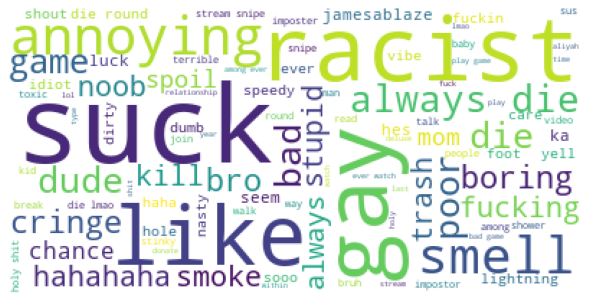

Hate Speech


<Figure size 432x288 with 0 Axes>

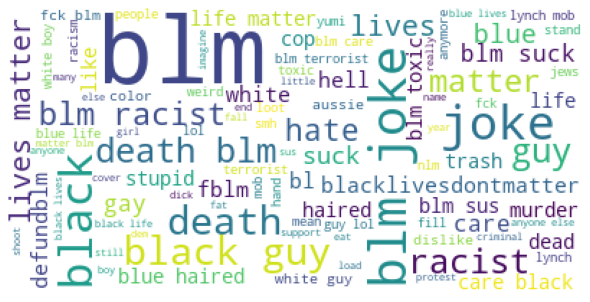

Sexual Harassment


<Figure size 432x288 with 0 Axes>

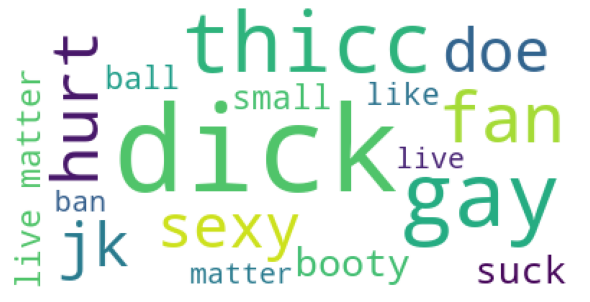

Trolling


<Figure size 432x288 with 0 Axes>

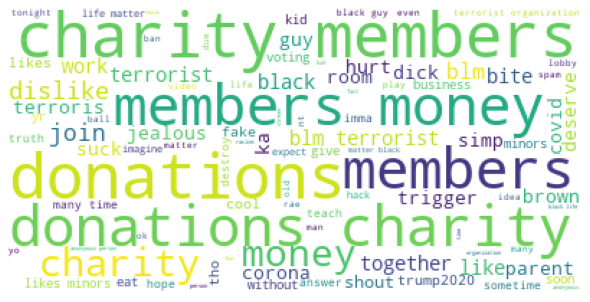

Others


<Figure size 432x288 with 0 Axes>

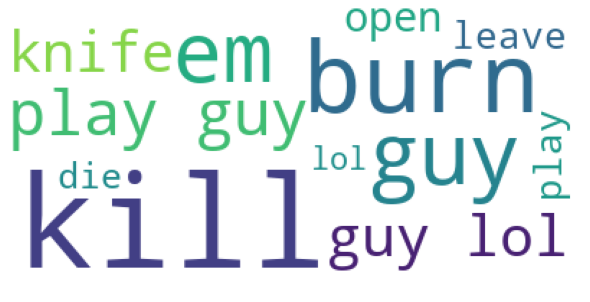

Toxic


<Figure size 432x288 with 0 Axes>

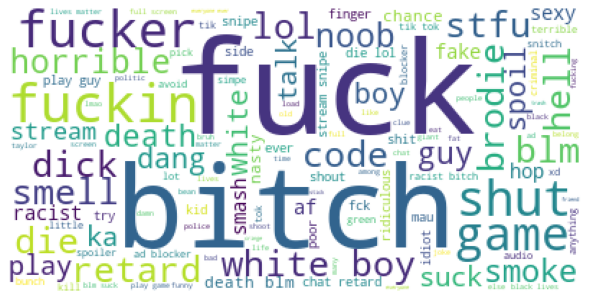

news_channel_GENRE.csv
Direct Harassment


<Figure size 432x288 with 0 Axes>

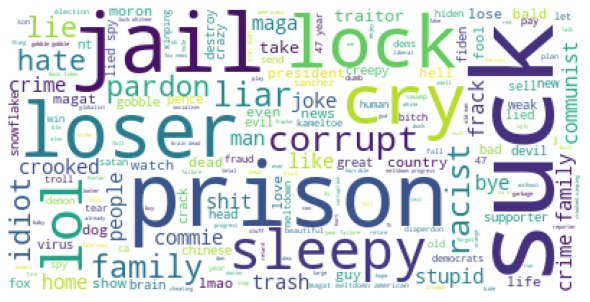

Hate Speech


<Figure size 432x288 with 0 Axes>

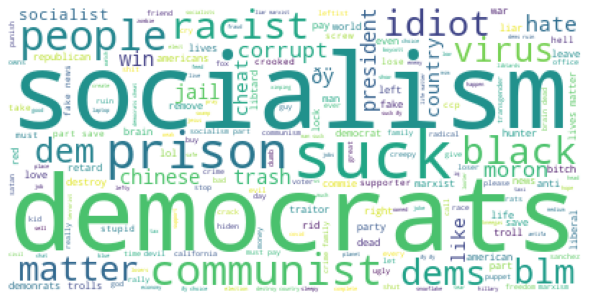

Sexual Harassment


<Figure size 432x288 with 0 Axes>

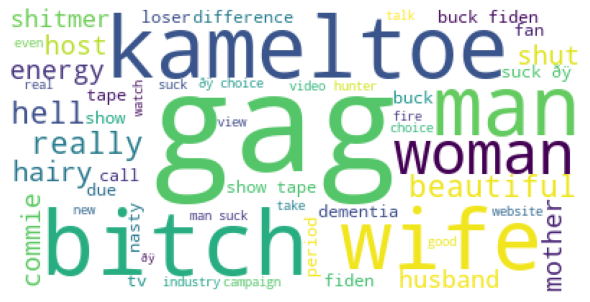

Trolling


<Figure size 432x288 with 0 Axes>

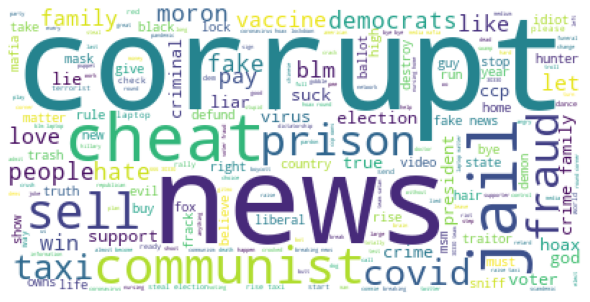

Others


<Figure size 432x288 with 0 Axes>

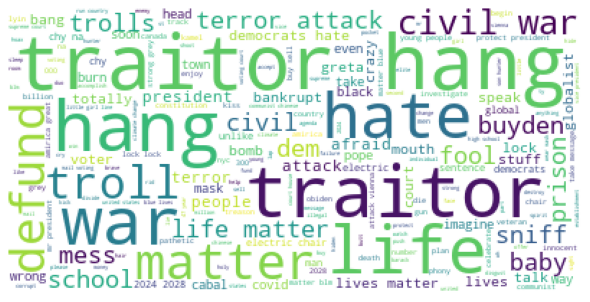

Toxic


<Figure size 432x288 with 0 Axes>

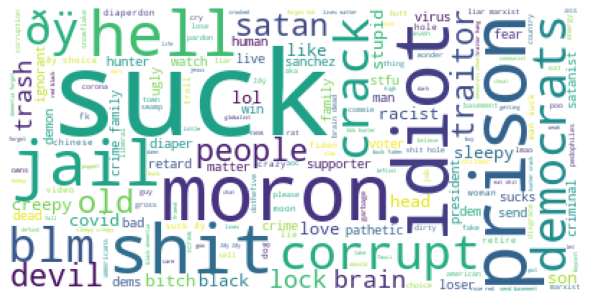

<Figure size 432x288 with 0 Axes>

In [177]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

src_folder = "tfidf_scores_WORDS_per_video_2/"
dest_folder = "tfidf_scores_WORDS_per_video_2/WORD_CLOUD_"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    features = df.columns.difference(labels)
    print(file)
    for label in labels:
        print(label)
        dl = df[df[label] == 1 ].drop(columns=labels)
        Cloud = WordCloud(background_color="white").generate_from_frequencies( dl.T.sum(axis=1))
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(Cloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()
        f = file.split(".csv")[0]
        plt.savefig(dest_folder + label + f + ".png",dpi = 300)
        

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

src_folder = "tfidf_scores_WORDS_per_video_2/"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    features = df.columns.difference(labels)
    print(file)
    for label in labels:
        print(label)
        dl = df[ (df[label] == 1) &  (df["Toxic"] == 0)  ].drop(columns=labels)
        dx = df[ (df[label] == 1) &  (df["Toxic"] == 1)  ].drop(columns=labels)
        t = df[(df["Toxic"] == 1) &  (df[label] == 1)].shape[0]
        d = df[(df[label] == 1) & (df["Toxic"] == 0) ].shape[0]
        total = df[(df[label] == 1)].shape[0]
        
        if label != 'Toxic':
            print(f"{d} /{total}\t\t{label} only")
            Cloud = WordCloud(background_color="white").generate_from_frequencies( dl.T.sum(axis=1))
            plt.figure(figsize = (8, 8), facecolor = None)
            plt.imshow(Cloud)
            plt.axis("off")
            plt.tight_layout(pad = 0)
            plt.show()
        if t > 0:
            print(f"{t} /{total}\t\t Toxic and {label}" )
            Cloud = WordCloud(background_color="white").generate_from_frequencies( dx.T.sum(axis=1))
            plt.figure(figsize = (8, 8), facecolor = None)
            plt.imshow(Cloud)
            plt.axis("off")
            plt.tight_layout(pad = 0)
            plt.show()

In [35]:
src_folder = "tfidf_scores_WORDS_per_video_2/"
dest_folder = "tfidf_scores_WORDS_per_video_2/"
top_dfs = []
for file in genre_files:
    vals = {}
    df = pd.read_csv(src_folder+file, index_col = 0)
    
    dfs = {}
    
    for label in labels:
        print(label)
        dl = df[ (df[label] == 1) &  (df["Toxic"] == 0)  ].drop(columns=labels)
        dx = df[ (df[label] == 1) &  (df["Toxic"] == 1)  ].drop(columns=labels)
        t = df[(df["Toxic"] == 1) &  (df[label] == 1)].shape[0]
        d = df[(df[label] == 1) & (df["Toxic"] == 0) ].shape[0]
        total = df[(df[label] == 1)].shape[0]
        
        if label != 'Toxic':
            dfs[label] = pd.DataFrame(dl.T.sum(axis=1).nlargest(50))
    display(dfs)

Direct Harassment
Hate Speech
Sexual Harassment
Trolling
Others
Toxic


{'Direct Harassment':                     0
 suck         3.143573
 gay          2.000000
 racist       2.000000
 like         1.741239
 annoying     1.440424
 always die   1.283172
 die          1.225110
 dude         1.161493
 boring       1.000000
 bro          1.000000
 cringe       1.000000
 fucking      1.000000
 hahahaha     1.000000
 kill         1.000000
 stupid       1.000000
 trash        1.000000
 always       0.900306
 chance       0.839553
 bad          0.828736
 mom          0.828195
 jamesablaze  0.808818
 hes          0.775256
 seem         0.762089
 luck         0.750974
 lightning    0.750618
 hole         0.749764
 yell         0.742482
 dirty        0.719352
 sooo         0.694646
 die round    0.672027
 dumb         0.669866
 vibe         0.668714
 care         0.660737
 speedy       0.660496
 haha         0.660332
 foot         0.657973
 smell        0.657973
 video        0.647472
 imposter     0.633384
 walk         0.633233
 impostor     0.631647
 shower      

KeyboardInterrupt: 

In [87]:
src_folder = "tfidf_scores_WORDS_per_video_2/"
dest_folder = "tfidf_scores_WORDS_per_video_2/CORR_"

for file in genre_files:
    #read file
    df = pd.read_csv(src_folder + file, index_col = 0)
    df = get_corr_vals(df)
    df.to_csv(dest_folder + file)
#src_folder = "tfidf_scores_WORDS_per_video_2/CORR_"
# for file in genre_files:
#     #read file
#     df = pd.read_csv(src_folder + file, index_col = 0)
#     display(df.head(5))